In [1]:
using HTTP
using Statistics
using PyPlot
using LinearAlgebra

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/cdesa/.julia/packages/PyPlot/4wzW1/src/init.jl:192


In [2]:

function process_libsvmdataset_line(line::AbstractString, num_features::Int64)
    (label_str, features_string) = split(line, " "; limit=2);
    label = parse(Float64, label_str);
    features = zeros(Float64, num_features);
    for f in split(features_string, " ")
        (i,v) = split(f, ":");
        features[parse(Int64,i)] = parse(Float64,v);
    end
    return (label,features);
end

function get_cpusmall_dataset()
    num_features = 12;
    r = HTTP.request("GET", "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression/cpusmall");
    @assert(r.status == 200);
    cpusmall_dataset_str = String(r.body);
    cpusmall_dataset_lines = split(strip(cpusmall_dataset_str), "\n");
    num_examples = length(cpusmall_dataset_lines);
    labels = zeros(num_examples);
    features = zeros(num_examples, num_features+1); #add one extra feature that's always 1, for the constant offset
    for i = 1:num_examples
        (label,feats) = process_libsvmdataset_line(cpusmall_dataset_lines[i], num_features);
        labels[i] = label;
        features[i,1:num_features] = feats;
        features[i,num_features+1] = 1.0;
    end
    return (labels, features);
end

get_cpusmall_dataset (generic function with 1 method)

In [3]:
# load the CPUsmall dataset from the libsvm datasets website
(cpusmall_labels, cpusmall_examples) = get_cpusmall_dataset();

This is a linear regression task, which has empirical risk
$$
R(w) = \frac{1}{n} \sum_{i=1}^n (x_i^T w - y_i)^2.
$$
The gradient is
$$
\nabla R(w) = \frac{2}{n} \sum_{i=1}^n x_i (x_i^T w - y_i).
$$

In [4]:
# loss of linear regression task
function linreg_loss(w::Array{Float64,1}, Xs::Array{Float64,2}, Ys::Array{Float64,1})
    return mean((Xs * w - Ys).^2);
end

# gradient of linear regression task
function linreg_grad(w::Array{Float64,1}, Xs::Array{Float64,2}, Ys::Array{Float64,1})
    return (Xs' * (Xs * w - Ys)) * (2/length(Ys))
end

function linreg_gradient_descent(Xs::Array{Float64,2}, Ys::Array{Float64,1}, alpha::Float64, w0::Array{Float64,1}, num_iters::Int64)
    w = w0;
    losses = zeros(num_iters + 1);
    for iter = 1:num_iters
        losses[iter] = linreg_loss(w, Xs, Ys);
        w = w - alpha * linreg_grad(w, Xs, Ys);
    end
    losses[num_iters+1] = linreg_loss(w, Xs, Ys);
    return (w, losses);
end

linreg_gradient_descent (generic function with 1 method)

In [5]:
# we can find the exact solution as follows
w_optimal = inv(cpusmall_examples' * cpusmall_examples) * cpusmall_examples' * cpusmall_labels;
loss_optimal = linreg_loss(w_optimal, cpusmall_examples, cpusmall_labels);

println("optimal loss: $loss_optimal");

optimal loss: 96.3657526859297


In [6]:
w0 = zeros(13);
alpha = 1e-13; # setting the step size larger results in divergence!
num_iters = 50;

(w_gd, losses_gd) = linreg_gradient_descent(cpusmall_examples, cpusmall_labels, alpha, w0, num_iters);

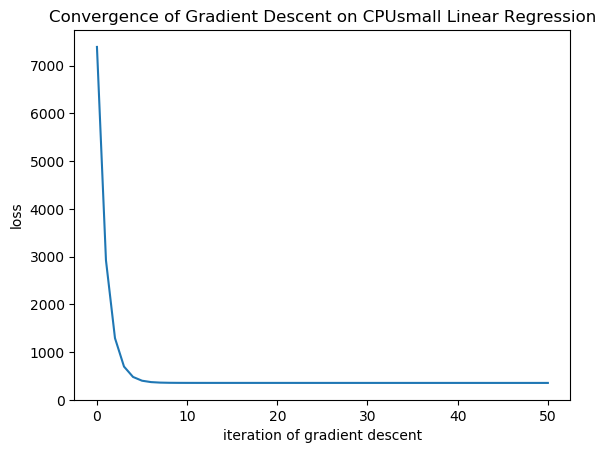

In [7]:
plot(collect(0:num_iters), losses_gd);
xlabel("iteration of gradient descent");
ylabel("loss");
title("Convergence of Gradient Descent on CPUsmall Linear Regression");

# Did gradient descent converge well on this example? Can we tell from this figure?

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.



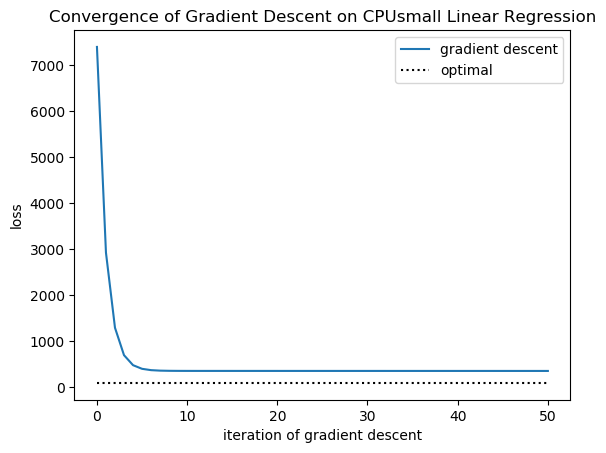

In [8]:
plot(collect(0:num_iters), losses_gd; label="gradient descent");
plot(collect(0:num_iters), 0 .* collect(0:num_iters) .+ loss_optimal; linestyle=":", c="k", label="optimal");
xlabel("iteration of gradient descent");
ylabel("loss");
title("Convergence of Gradient Descent on CPUsmall Linear Regression");
legend();

# What went wrong? How could we fix this?

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

## Maybe looking at the dataset would help!

In [9]:
cpusmall_examples[1,:]

13-element Array{Float64,1}:
      6.0       
      2.0       
   1036.0       
    103.0       
    114.0       
      1.0       
      1.0       
 172076.0       
 355965.0       
      2.0       
   6527.0       
      1.851864e6
      1.0       

## Does this give any new insights?

.

.

.

.

.

.

.

.

.

.

.

.

.

.


In [10]:
# normalize the examples in two ways

# mean = 0, variance = 1
cpusmall_mean = mean(cpusmall_examples; dims=1);
cpusmall_mean[13] = 0.0;
cpusmall_var = mean((cpusmall_examples .- cpusmall_mean).^2; dims=1);
cpusmall_normalized1 = (cpusmall_examples .- cpusmall_mean) ./ sqrt.(cpusmall_var);

# scale by max all features lie in [-1,1]
cpusmall_max = maximum(abs.(cpusmall_examples); dims=1);
cpusmall_normalized2 = cpusmall_examples ./ cpusmall_max;

In [11]:
# we can find the exact solution as follows
w_opt_normalized1 = inv(cpusmall_normalized1' * cpusmall_normalized1) * cpusmall_normalized1' * cpusmall_labels;
loss_opt_normalized1 = linreg_loss(w_opt_normalized1, cpusmall_normalized1, cpusmall_labels);

w_opt_normalized2 = inv(cpusmall_normalized2' * cpusmall_normalized2) * cpusmall_normalized2' * cpusmall_labels;
loss_opt_normalized2 = linreg_loss(w_opt_normalized2, cpusmall_normalized2, cpusmall_labels);

# should all be the same
println("optimal loss (without normalization): $loss_optimal");
println("optimal loss (with  normalization 1): $loss_opt_normalized1");
println("optimal loss (with  normalization 2): $loss_opt_normalized2");

optimal loss (without normalization): 96.3657526859297
optimal loss (with  normalization 1): 96.36575268592969
optimal loss (with  normalization 2): 96.36575268592969


In [12]:
w0 = zeros(13);
alpha = 0.1; # setting the step size larger results in divergence!
(w_gdn, losses_gdn1) = linreg_gradient_descent(cpusmall_normalized1, cpusmall_labels, alpha, w0, num_iters);

w0 = zeros(13);
alpha = 0.5; # setting the step size larger results in divergence!
(w_gdn, losses_gdn2) = linreg_gradient_descent(cpusmall_normalized2, cpusmall_labels, alpha, w0, num_iters);

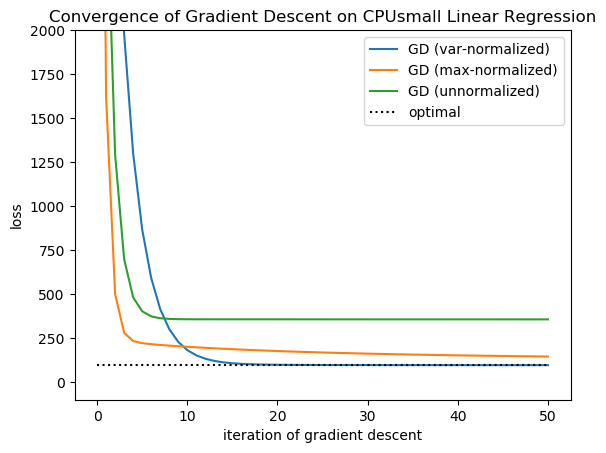

In [13]:
plot(collect(0:num_iters), losses_gdn1; label="GD (var-normalized)");
plot(collect(0:num_iters), losses_gdn2; label="GD (max-normalized)");
plot(collect(0:num_iters), losses_gd; label="GD (unnormalized)");
plot(collect(0:num_iters), 0 .* collect(0:num_iters) .+ loss_optimal; linestyle=":", c="k", label="optimal");
xlabel("iteration of gradient descent");
ylabel("loss");
title("Convergence of Gradient Descent on CPUsmall Linear Regression");
ylim((-100,2000))
legend();

Can we interpret this in terms of the condition number?

For linear regression, $$\nabla^2 R(w) = 2 \frac{1}{n} \sum_{i=1}^n x_i x_i^T.$$

In [14]:
D2R_unnormalized = (cpusmall_examples' * cpusmall_examples) * 2 / length(cpusmall_labels);
D2R_normalized1 = (cpusmall_normalized1' * cpusmall_normalized1) * 2 / length(cpusmall_labels);
D2R_normalized2 = (cpusmall_normalized2' * cpusmall_normalized2) * 2 / length(cpusmall_labels);

In [15]:
function condition_number(H::Array{Float64,2})
    # make sure H is symmetric for the eigendecomposition
    H = (H + H') / 2;
    ev = eigvals(H);
    mu = minimum(ev);
    L = maximum(ev);
    kappa = L / mu;
    return kappa;
end

condition_number (generic function with 1 method)

In [16]:
println("unnormalized, kappa = $(condition_number(D2R_unnormalized))")

unnormalized, kappa = 4.994306826469933e13


In [17]:
println("var normalized, kappa = $(condition_number(D2R_normalized1))")

var normalized, kappa = 43.8053033546088


In [18]:
println("max normalized, kappa = $(condition_number(D2R_normalized2))")

max normalized, kappa = 14128.211688196825


# What can we conclude from this demo?